In [1]:
import os, sys
sys.path.append("../")

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib import gridspec
import numpy as np
import pandas as pd
from tqdm import *
from celluloid import Camera

from grf.units import *
from grf.pk_interp import PowerSpectrumGridInterpolator
from grf.grf import FIRAS

from IPython.display import set_matplotlib_formats
from IPython.display import HTML
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [3]:
# Load an instance of FIRAS class with nonlinear matter power spectrum
firas = FIRAS(PowerSpectrumGridInterpolator("nonlin_matter_bj"))

../grf/grf.py:595: FutureWarning: read_table is deprecated, use read_csv instead.
  names=['freq', 'I', 'residual', 'uncert', 'poles'])


In [4]:
def as_si(x, ndp, dolla=0):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    if float(m) == 1.:
        s = r'10^{{{e:d}}}'.format(m=m, e=int(e))
    else:
        s = r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))
    if dolla:
        return '$' + s + '$'
    else:
        return s

In [5]:
def make_snap(m_A, gs):
    
    # Top plot
    ax0 = plt.subplot(gs[0])

    ## Frequency bins to plot
    i_freq_ary = [0]

    z_ary_plot = np.logspace(-2, 4, 30000)

    ls_list = ['-','--',':','-.']

    ## Plot central values
    for i_en_freq_ry, i_freq in enumerate(i_freq_ary):
        ax0.plot(z_ary_plot, np.sqrt(firas.m_A_sq(z_ary_plot, firas.omega_FIRAS[i_freq] * (1 + z_ary_plot))) / eV , ls=ls_list[i_en_freq_ry], color='k', lw=1.5)

    ## For the first frequency bin, plot 1- and 2-sigma containment regions

    i_freq = 0

    z_ary_fluc, dP_dz_ary, P_tot, sigma_sq_ary = firas.P_tot_perturb([firas.omega_FIRAS[i_freq]], 1e-1, m_A * eV, k_max=1e3, pdf='lognormal')
    m_A_ary = (firas.m_A_sq(z_ary_fluc, firas.omega_FIRAS[i_freq] * (1 + z_ary_fluc))) / eV ** 2

    ax0.fill_between(z_ary_fluc,  np.nan_to_num(np.sqrt(m_A_ary * np.exp(- 1 * np.sqrt(sigma_sq_ary[0])))) , np.nan_to_num(np.sqrt(m_A_ary * 1 * np.exp(np.sqrt(sigma_sq_ary[0])))), alpha=0.8, color='lightgrey', lw=0.5)
    ax0.fill_between(z_ary_fluc,  np.nan_to_num(np.sqrt(m_A_ary * np.exp(- 2 * np.sqrt(sigma_sq_ary[0])))) , np.nan_to_num(np.sqrt(m_A_ary * 2 * np.exp(np.sqrt(sigma_sq_ary[0])))), alpha=0.3, color='lightgrey', lw=0.5)

    ## Horizontal lines for benchmark points

    ax0.axhline(m_A / eV, lw=1.5, ls='-', color=cols_default[0], alpha=0.7)

    ax0.set_xscale("log")
    ax0.set_yscale("log")

    ax0.set_xlim(np.min(z_ary_plot), np.max(z_ary_plot))
    ax0.set_ylim(1e-16, 1e-7)

    ax0.set_ylabel("$m_\gamma$\,[eV]")
    ax0.set_xlabel("$z$")

    # Bottom plot

    ax1 = plt.subplot(gs[1])

    ## Get and plot dP/dz for benchmark mass points 
    z_ary, dP_dz_ary, _, _  = firas.P_tot_perturb([firas.omega_FIRAS[0]], 1., m_A, z_max = 2000., n_z_bins=10000)
    ax1.plot(z_ary, z_ary * (dP_dz_ary[0] / np.trapz(dP_dz_ary[0], z_ary)), c=cols_default[0], lw=1.5)

    ax1.set_xscale("log")
    ax1.set_yscale("log")

    ax1.set_xlim(np.min(z_ary_plot), np.max(z_ary_plot))
    ax1.set_ylim(1e-4, 1e2)

    ax1.set_xlabel("$z$")
    ax1.set_ylabel(r"$\mathrm d\langle P_{\gamma\rightarrow A^\prime }\rangle/\mathrm d\log z$", fontsize=14, labelpad=17.)

    # Plot attributes

    plt.setp(ax0.get_xticklabels(), visible=False)

    plt.suptitle(r"\textbf{Plasma Mass and Oscillation Probability}", fontsize=17., y=0.93, x=0.51)

    # Tick tweaks

    locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
    ax0.yaxis.set_major_locator(locmaj)

    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
    ax0.yaxis.set_minor_locator(locmin)
    ax0.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    ax1.set(yticks=[1e-4, 1e-3, 1e-2, 1e-1 ,1 , 10, 1e2], yticklabels=[as_si(1e-4,1, dolla=1), None, as_si(1e-2,1, dolla=1), None , "$10^0$" , None, as_si(1e2, 1, dolla=1)])
    
    plt.tight_layout()

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be creat

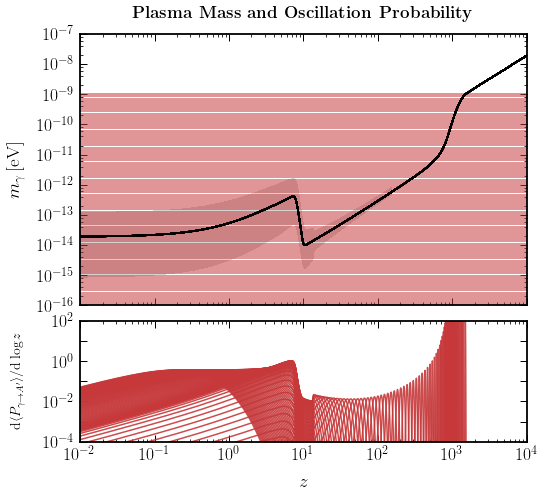

In [6]:
m_A_ary = np.logspace(-16, -9, 100)[::-1] * eV

fig, axs = plt.subplots(figsize=(8, 7.5)) 
cam = Camera(fig)

gs = gridspec.GridSpec(2, 1, height_ratios=[2.25, 1], hspace=0.08) 

for m_A in tqdm_notebook(m_A_ary[:]):
    make_snap(m_A, gs)
    cam.snap()

In [7]:
anim = cam.animate()

In [8]:
# HTML(anim.to_html5_video())

In [11]:
anim.save('/Users/smsharma/Desktop/animation.mp4', fps=12., dpi=100)

In [107]:
# anim.save('/Users/smsharma/Desktop/animation.gif', writer='imagemagick', fps=12)